
Over the past decade, a number of studies have revealed associations between microbiome diversity and/or composition and ASD phenotypes. However, as is the case with a majority of microbiome and other omics analyses across diseases, there is little agreement among studies due to inherent biological and computational challenges associated with acquiring, processing and interpreting such data.

To determine whether the existing studies could be used to objectively inform the design of the next generation of microbiome studies in ASD, we set out to re-analyze the datasets using a standardized and data-driven probabilistic modeling approach a.k.a. a Bayesian approach. We chose this strategy to maximize the amount of information that could be extracted from each individual study and to minimize biases introduced by traditional model-driven statistical methods a.k.a. frequentist methods. The resulting analytical pipeline can be universally applied to different types of omics datasets to help determine information flow across biological organization levels.

Here we present initial results from the integrated analysis of nine 16S amplicon datasets, four shotgun datasets and four RNAseq datasets using a customized age- and sex-matched differential abundance approach—in the ASD cohorts studies, age and sex are the top parameters associated with microbiome and ASD phenotype, respectively.

The most salient result of our analysis is the high level of convergence among studies; the case-control differential abundance models were able to detect strong ASD-specific differences in microbial taxa abundances and human expression data (pvalue<0.0005) while explaining the majority of the variation across these three datasets (16S, Shotgun metagenomics, RNAseq ). This Bayesian approach provides a solid framework for the design and analysis of future studies aiming to a better understanding of a potential causal role of the microbiome in ASD. 

In this notebook we first lay out the rationale for the differential abundance approach we applied to the analysis of the above datasets. Next we show how we obtained metabolic pathway information from the top ASD associated microbes and transcripts, We then describe how we constructed a comprehensive metabolic map that integrates the different omic levels analyzed. Finally, we provide an independent validation of our differential abundance amplicon analysis using data from an interventional fecal matter transplant study. A detailed description of the data processing and the bioinformatic pipeline construction can be found in the appendix.

Technical note: all analyses described in this notebook have been done using preprocessed datasets and can thus be executed in real time from the code blocks if needed. Note that we have designed the notebook with readability in mind and thus it is not necessary to run the  code blocks to follow the narrative and/or see the figures. Please contact Gaspar (gtaroncher-consultant@simonsfoundation.org) and Jamie (jmorton@flatironinstitute.org) if you have any questions.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Differential-Ranking-Analysis" data-toc-modified-id="Differential-Ranking-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Differential Ranking Analysis</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Appendix</a></span><ul class="toc-item"><li><span><a href="#Statistical-overview" data-toc-modified-id="Statistical-overview-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Statistical overview</a></span><ul class="toc-item"><li><span><a href="#Differential-Ranking" data-toc-modified-id="Differential-Ranking-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Differential Ranking</a></span></li><li><span><a href="#A-Brief-Primer-to-Bayesian-Inference" data-toc-modified-id="A-Brief-Primer-to-Bayesian-Inference-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>A Brief Primer to Bayesian Inference</a></span></li><li><span><a href="#Bayesian-Hypothesis-testing" data-toc-modified-id="Bayesian-Hypothesis-testing-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Bayesian Hypothesis testing</a></span></li><li><span><a href="#Bayesian-Effect-Size-Calculations" data-toc-modified-id="Bayesian-Effect-Size-Calculations-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Bayesian Effect Size Calculations</a></span></li></ul></li><li><span><a href="#Datasets-analyzed" data-toc-modified-id="Datasets-analyzed-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Datasets analyzed</a></span><ul class="toc-item"><li><span><a href="#16S-amplicon-datasets" data-toc-modified-id="16S-amplicon-datasets-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>16S amplicon datasets</a></span></li><li><span><a href="#Shotgun-metagenomic-datasets" data-toc-modified-id="Shotgun-metagenomic-datasets-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Shotgun metagenomic datasets</a></span></li><li><span><a href="#RNAseq-datasets" data-toc-modified-id="RNAseq-datasets-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>RNAseq datasets</a></span></li></ul></li><li><span><a href="#Bioinformatics-Overview" data-toc-modified-id="Bioinformatics-Overview-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Bioinformatics Overview</a></span><ul class="toc-item"><li><span><a href="#16S-amplicon-datasets" data-toc-modified-id="16S-amplicon-datasets-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>16S amplicon datasets</a></span></li><li><span><a href="#Shotgun-metagenomics" data-toc-modified-id="Shotgun-metagenomics-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Shotgun metagenomics</a></span></li><li><span><a href="#RNA-sequencing-data" data-toc-modified-id="RNA-sequencing-data-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>RNA sequencing data</a></span></li></ul></li></ul></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials,
                  match_all_differentials_and_tree)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp-v2'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

# Differential Ranking Analysis

Differential abundance analysis seeks to detect differentially abundant omic features (species, OTUs, metabolites, cytokines,...) between two conditions. While such an analysis can improve our understanding of the aetiology of a disease and potentially lead to preventive or therapeutic strategies, the compositional nature of omics data, and in particular microbiome data, poses unique challenges for performing traditional differential abundance analysis.

First, and because no absolute microbial abundances can be determined at the time of sampling (concentrations, cells/gram, ...), it is not possible to determine absolute changes in microbial abundances. Instead, one is limited to determine relative abundances and then use log-fold change up to a constant bias to ‘sort’ microbes, or any other omics feature characterized by the same sampling limitations to show relative degrees of ‘perturbation’ across all features present in an omic dataset (see [this paper](https://www.nature.com/articles/s41467-019-10656-5) on a full explanation).  

The second major challenge is dealing with batch effects. Due to differences in collection and processing protocols, different studies are no longer directly comparable. Adopting an approach that zeroes out such batch effects by making the differential analysis study-specific can help minimize any batch-related confounders in a combined analysis.

Due to these and other challenges, differential abundance analysis remains one of the more controversial approaches to analyzing microbiome datasets. 

Here, and in order to address these challenges by maximizing the amount of information we could extract from the datasets while minimizing any batch-related confounders, we designed a customized differential abundance tool that could leverage the experimental designs of each of the studies included in the analysis. Specifically, we incorporated age-sex matching into the statistical models to allow us to determine feature perturbation profiles within the context of each individual study followed by a combined analysis of the normalized perturbation profiles of different studies. The overall model had the following structure

$$
y_{i,j} \sim NegativeBinomial(\lambda_{i,j}, \alpha_j)\\
\log \lambda_{i,j} = \log N_i + C_{k(i), j} + \Delta_j \textrm{I}[i=ASD]
$$

Here $y_{i,j}$ denotes the microbial counts in sample $i$ and species $j$ and $\alpha_j$ represents the microbe specific over-dispersion term. The sequencing depth is represented by $N_i$. By incorporating $N_i$ into the model, the model is self-normalizing and doesn't need rarefaction.  $C_{k(i), j}$ represents the log proportion of microbe $j$ in the $k(i)$ control subject.  This is where the age-sex matching comes in; $k(i)$ denotes the pairing that sample i belongs to.
$\Delta_j$ represents microbe log-fold change difference between the control and ASD subject, the quantity that we are interested in.  For finishing touches, $\textrm{I}[i=ASD]$ a function that is 0 if sample i corresponds to the control subject and 1 is sample i corresponds to the ASD subject.  See the supplemental materials for the full detailed model, since we aren't including all of the priors or batch effects terms here.

One advantage of using the above model is that if the batch effects are multiplicative (e.g., PCR amplification bias), they will cancel out and will not impact the calculation of $\Delta_j$. In addition, the above model structure provides a template for fitting a differential abundance model to different types of omics data.

The model was fitted using a Monte-Carlo Markov Chain (MCMC) approach. Because MCMC is a computationally very intensive method, we ran the model fittings shown here offline to make the notebook operational.

In [2]:
!ls -lhrt ../sfari/data/sra/Kang2017/week0

total 3.3G
-rw-rw-r-- 1 jmorton jmorton 3.3G Aug 11 12:30 differentials-v7.nc
-rw-rw-r-- 1 jmorton jmorton    0 Aug 23 14:11 slurm-1557320.out


In [3]:
!ls -lhrt ../sfari/data/sra_shotgun/Combined/age_sex_matched_posterior

total 76G
-rw-rw-r-- 1 jmorton jmorton  33G Jun  2  2021 differential_posterior.nc
-rw-rw-r-- 1 jmorton jmorton  12G Jun 25  2021 viral_differentials.nc
-rw-rw-r-- 1 jmorton jmorton 9.4G Jul 30  2021 ogus_differentials-v2.nc
-rw-rw-r-- 1 jmorton jmorton 2.6G Jul 30  2021 viral_differentials-v2.nc
-rw-rw-r-- 1 jmorton jmorton 2.4G Sep 13  2021 viral_differentials-v3.nc
-rw-rw-r-- 1 jmorton jmorton 6.9G Sep 13  2021 ogus_differentials-v3.nc
-rw-rw-r-- 1 jmorton jmorton 2.3G Oct 25  2021 ogus_differentials-v4.nc
-rw-rw-r-- 1 jmorton jmorton 764M Oct 27  2021 viral_differentials-v4.nc
-rw-rw-r-- 1 jmorton jmorton 787M Oct 29  2021 viral_differentials-v5.nc
-rw-rw-r-- 1 jmorton jmorton 2.4G Oct 29  2021 ogus_differentials-v5.nc
-rw-rw-r-- 1 jmorton jmorton 5.1G Aug 11 17:41 ogus_differentials-v7.nc


In [4]:
# load 16S, whole genome shotgun and RNAseq data
posterior_name = 'age_sex_matched_posterior'
#amp_fname = f'{amp_directory}/{posterior_name}/amp_differentials-v4.nc'
#amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
amp_fname = f'{kang_directory}/week0/differentials-v7.nc'
wgs_fname = f'{wgs_directory}/{posterior_name}/ogus_differentials-v7.nc'
rna_fname = f'{rna_directory}/{posterior_name}/rna_differentials-v4.nc'
vir_fname = f'{wgs_directory}/{posterior_name}/viral_differentials-v5.nc'

amp_diffs = extract_differentials(amp_fname)
wgs_diffs = extract_differentials(wgs_fname)
rna_diffs = extract_differentials(rna_fname)
vir_diffs = extract_differentials(vir_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_percentile=90)
wgs_stats = ranking(wgs_diffs, reference_percentile=90)
rna_stats = ranking(rna_diffs, reference_percentile=90)
vir_stats = ranking(vir_diffs, reference_percentile=90)

One of the benefits of fitting these models in a Bayesian setting is that we were able to quantify the uncertainty surrounding the parameters of interest. This was crucial for us since we wanted to be able to quantify how well we could estimate the microbial log-changes between the control and ASD subjects. Doing so allowed us to compute Bayesian p values along with a full array of statistics. Here, we will focus on a one-sided T-test to identify the top 5% most differentially increased microbes. Specifically, we will use the following statistic

$$
t_j = \frac{\bar{\Delta_j} - \Delta_{90\%}}{s_j / M}
$$

We calculate this T-statistic using draws from the *posterior distribution* of $\Delta_j$, from which we can compute p-values. Here $\bar{\Delta_j}$ represents the average log-fold change for microbe $j$, $\Delta_{90\%}$ represents the expected log-fold for the $90\%$th most differentially increased microbe, $s_j$ represents the estimated standard deviation from $M$ posterior draws.  Computing this quantity will allow us to focus our attention to the top 10% most differentially increased microbes in ASD subjects.  And because we are in a Bayesian setting, we can easily compute these quantities by explicitly sampling from the *posterior distribution* of $\Delta_j$ (Please, refer to the Appendix for a detailed explanation of these concepts).

The reason why we should this approach rather than comparing against medians and averages as done in DESeq2 and Aldex2 is because these enforce extremely strong assumptions that typically do not hold in practice and yield extremely high false positive rates. By only investigating the top 5% most differentially abundant features, we adopt a much more conservative approach.

We applied this differential abundance approach to 16S amplicon data, metagenomic shotgun sequencing data and RNAseq data (we are in the process of applying the same approach to virome data and metabolome data as well). Plotted below are the log-fold change estimates across eight 16S amplicon datasets, four metagenomic datasets and four RNAseq datasets.

In [5]:
rna_stats['mean'].describe()

count    4.799200e+04
mean    -1.184435e-18
std      3.205264e-01
min     -5.995074e+00
25%     -1.591946e-01
50%     -2.012532e-02
75%      1.642757e-01
max      2.525232e+00
Name: mean, dtype: float64

In [6]:
wgs_stats['mean'].describe()

count    9.799000e+03
mean    -3.074499e-16
std      1.703007e+00
min     -8.317397e+00
25%     -4.011225e-01
50%      6.538740e-01
75%      1.090601e+00
max      4.843822e+00
Name: mean, dtype: float64

In [7]:
vir_stats['mean'].describe()

count    1.575000e+03
mean     8.120488e-17
std      2.437907e+00
min     -6.850338e+00
25%     -2.530964e+00
50%      1.129435e-01
75%      2.220030e+00
max      7.134130e+00
Name: mean, dtype: float64

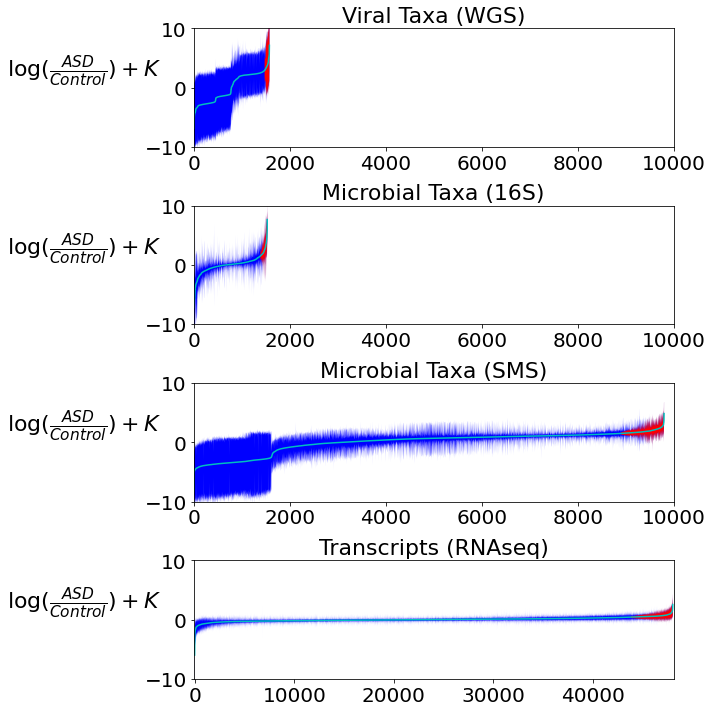

In [8]:
matplotlib.rcParams['text.usetex'] = False
# Plot the log-fold changes
#with plt.style.context('dark_background'):
fig, ax = plt.subplots(4, 1, figsize=(10, 10))
fs, ls = 22, 20
rankplot(vir_stats, ax[0])
ax[0].set_title('Viral Taxa (WGS)', fontsize=fs)
ax[0].set_ylim([-10, 10])
ax[0].set_xlim([-5, 10000])
ax[0].set_ylabel(r'$\log(\frac{ASD}{Control})+K$', fontsize=fs, labelpad=60)
ax[0].tick_params(axis='x', labelsize=ls)
ax[0].tick_params(axis='y', labelsize=ls)

rankplot(amp_stats, ax[1])
ax[1].set_title('Microbial Taxa (16S)', fontsize=fs)
ax[1].set_ylim([-10, 10])
ax[1].set_xlim([-5, 10000])
ax[1].set_ylabel(r'$\log(\frac{ASD}{Control})+K$', fontsize=fs, labelpad=60)
ax[1].tick_params(axis='x', labelsize=ls)
ax[1].tick_params(axis='y', labelsize=ls)

rankplot(wgs_stats, ax[2])
ax[2].set_title('Microbial Taxa (SMS)', fontsize=fs)
ax[2].set_ylim([-10, 10])
ax[2].set_xlim([-5, 10000])
ax[2].set_ylabel(r'$\log(\frac{ASD}{Control})+K$', fontsize=fs, labelpad=60)
ax[2].tick_params(axis='x', labelsize=ls)
ax[2].tick_params(axis='y', labelsize=ls)

rankplot(rna_stats, ax[3])
ax[3].set_ylim([-10, 10])
ax[3].set_title('Transcripts (RNAseq)', fontsize=fs)
ax[3].set_xlim([-100, len(rna_stats) + 100])
ax[3].set_ylabel(r'$\log(\frac{ASD}{Control})+K$', fontsize=fs, labelpad=60)
ax[3].tick_params(axis='x', labelsize=ls)
ax[3].tick_params(axis='y', labelsize=ls)

plt.tight_layout()

There are two parts to each figure. We have plotted the 95% credible intervals for each microbe’s log-fold change estimate. Due to the unknown bias denoted by $K$, we cannot exactly identify where 0 is, motivating our ranking strategy highlighted above. The red portion of the curve denotes the microbes that are amongst the top 5% microbes differentially increased in the ASD subjects.


You can see that there is **much** large magnitude of change in the microbiome datasets (roughly $10^6$) compared to the RNAseq datasets (roughly $10^3$). We can perform a Bayesian hypothesis test to put a hard number on the differences in this effect size.

In [9]:
vir_diffs.shape, amp_diffs.shape, wgs_diffs.shape, rna_diffs.shape

((1575, 400), (1530, 400), (9799, 400), (47992, 400))

In [10]:
# Perform Bayesian hypothesis test
from q2_matchmaker._stats import spherical_test
w_vir, vir_r, vir_z = spherical_test(vir_diffs.values.T, percentile=100)
w_amp, amp_r, amp_z = spherical_test(amp_diffs.values.T, percentile=100)
w_wgs, wgs_r, wgs_z = spherical_test(wgs_diffs.values.T, percentile=100)
w_rna, rna_r, rna_z = spherical_test(rna_diffs.values.T, percentile=100)

vir_e = vir_z / vir_r
amp_e = amp_z / amp_r
wgs_e = wgs_z / wgs_r
rna_e = rna_z / rna_r

print(f'[Viral] ASD diff detected {not w_vir}, '
      f'Effect size {vir_e}')
print(f'[16S] ASD diff detected {not w_amp}, '
      f'Effect size {amp_e}')
print(f'[WGS] ASD diff detected {not w_wgs}, '
      f'Effect size {wgs_e}')
print(f'[RNA] ASD diff detected {not w_rna}, '
      f'Effect size {rna_e}')

[Viral] ASD diff detected False, Effect size 0.7830470288170371
[16S] ASD diff detected True, Effect size 1.090750110582444
[WGS] ASD diff detected True, Effect size 1.1052807456909202
[RNA] ASD diff detected True, Effect size 1.0902623462382215


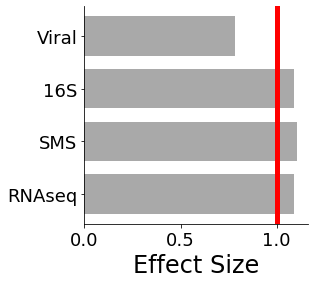

In [11]:
#with plt.style.context('dark_background'):
effect_sizes = [vir_e, amp_e, wgs_e, rna_e]
omics_levels = ['Viral', '16S', 'SMS', 'RNAseq']
fig, ax = plt.subplots(figsize=(4, 4))
idx = [0, 1, 2, 3]
ax.barh(idx, effect_sizes[::-1], height=0.75, color='#A9A9A9')
ax.set_yticks(idx)
ax.set_yticklabels(omics_levels[::-1], fontsize=18)
ax.set_xlabel('Effect Size', fontsize=24)
ax.tick_params(axis='x', labelsize=18)
ax.axvline(x=1, c='r', lw=5)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [12]:
# Align against taxonomy
gg_taxonomy = pd.read_table('~/ceph/gg2/2022.8/2022.8.taxonomy.id.tsv', index_col=0)

taxa_md = pd.DataFrame(
    list(gg_taxonomy.loc[amp_stats.index].Taxon.apply(lambda x: x.split(';')).values),
    index=amp_stats.index,
)
taxa_cols = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
taxa_md.columns = taxa_cols
amp_stats = pd.merge(amp_stats, taxa_md, left_index=True, right_index=True, how='left')
for col in taxa_cols:
    amp_stats[col] = amp_stats[col].apply(lambda x: x.split('__')[-1])
    
wol_taxonomy = pd.read_table('~/ceph/wol2/wol2/taxonomy/ranks.tsv', index_col=0)
wgs_stats = pd.merge(wgs_stats, wol_taxonomy, left_index=True, right_index=True, how='left')

def clean_f(x):
    x.pop('effect_size')
    x.pop('effect_std')
    return x

# Save supplemental tables
clean_f(amp_stats).to_csv('../results/supplemental_tables/Table_S4.csv')
clean_f(wgs_stats).to_csv('../results/supplemental_tables/Table_S5.csv')
clean_f(rna_stats).to_csv('../results/supplemental_tables/Table_S6.csv')
clean_f(vir_stats).to_csv('../results/supplemental_tables/Table_S7.csv')

# Appendix

## Statistical overview

### Differential Ranking

The common goal of perform differential abundance is to try to identify which features have "changed" across the experimental conditions.  In my field, we are often trying to identify microbes or genes that have "changed" in abundance to determine if microbes have grown or declined across conditions.  When we mean by "changed", we are
interested in determine if the fold change across conditions is equal to one or not, in particular, $$\frac{A_i}{B_i} = 1$$ for abundances in conditions $A$ and $B$ for a given feature $i$.

We have liberally highlighted the term "change", because this notion is no longer fully observed, if we only observe data of proportions.  For the reason being that we are missing a key variable of interest, the total number of individuals in each experimental condition. 

Specifically, if we cannot directly observe $A_i$ or $B_i$, but can observe their proportions $p_{A_i}$, $p_{B_i}$ we can no longer make concrete statements about "change" because we can't observe the total number of individuals $N_A$ and $N_B$.  In particular, we have a bias term $\frac{N_A}{N_B}$ given by

$$\frac{A_i}{B_i} = \frac{N_A p_{A_i}}{N_B p_{B_i}} = \frac{N_A}{N_B} \times \frac{p_{A_i}}{p_{B_i}}$$

As a result, any statement of change that we make will be confounded by the change in $N$. 
To see a concrete example, see [Figure 1 and 2 in this paper](https://www.nature.com/articles/s41467-019-10656-5).

There are two ways to detail with this, namely computing ratios or rankings.
Ratios are appealing since they are scale-invariant, namely the dependence on the total microbial load will be dropped.   Specifically, if we consider two features $i$ and $j$ and compute their ratio, the following holds

$$
\frac{p_{A_i} / p_{A_j}}{p_{B_i} / p_{B_j}} = \frac{A_i / A_j}{B_i / B_j}
$$

The other approach, ranking, takes an approach that is closer to traditional differential abundance tools such as edgeR, DEseq2 and aldex2.

The microbial load bias will impact every species equally, meaning that if we can ***ignore*** this bias, this approach would be scale-invariant as well.  We can do this by merely focusing on the ordering of the log-fold changes rather than log-fold change values themselves.

$$rank\bigg(\frac{A_i}{B_i}\bigg) = rank\bigg(\frac{N_A}{N_B} \times \frac{p_{A_i}}{p_{B_i}}\bigg) = rank\bigg(\frac{p_{A_i}}{p_{B_i}}\bigg)$$

In a practical way, what this is saying is that if we don't have the absolute abundances, we can't say for certain what exactly is changing -- the best that we can do is sort the microbes by their log-fold changes and prioritize them accordingly.  This also has a number of disturbing implications for standard differential abundance statistical testing (a discussion topic for another time).

### A Brief Primer to Bayesian Inference

What is Bayesian inference exactly, and how does it differ from Frequentist inference?
Mathematically, there isn't actually a difference between the two frameworks, but there are philosophical differences.  The big assumption boils down to how uncertainty should be modeled. Namely

- Frequentist approaches assume there is no uncertainty in the underlying system. Namely all model parameters have an exact ground truth, and can be perfectly estimated if infinitely number of samples can be collected.
- Bayesian approaches assume uncertainty in the underlying system due to measurement error.  Because we can not exactly measure systems (i.e. sampling error, calibration error), we can never perfectly estimate the model parameters - the best we can do is get a reasonable ballpark estimate by explicitly modeling the uncertainty.

Ok, that's the philosophy, but how can these contradictory ideas exist in the same mathematical framework.  Everything boils down to Bayes theorem

$$ P(state | data) = P(data | state) \; P(state) $$

We're denoting "state" as the underlying model parameters (i.e. log fold change) that we want to estimate. $P(data | state)$ denotes the data likelihood, the probability of observing the data given a specific "state". $P(state)$ denotes the prior probability of the state, the observes best guess what the state could be.  $P(state | data)$ denotes the probability of observing a state given the data. This entire process is known as a Bayesian update, given a prior belief of the system and observational data, the model parameter along with their corresponding uncertainties are updated accordingly.

The only mathematical difference boils down to the choice of prior.  Frequentist approaches assume that we do not know anything about the system, and thus assume a *flat prior*.  Unfortunately, this approach is simply not practical for biological problems where the sheer number of resources (i.e. size of biological datasets) required to accurately fit these models would be astronomical.  Biological systems are extremely high dimensional and often sparse, consisting of thousands of dimensions, where 90% of the matrix entries aren't observed. To make frequentist inference tractable, many practioners will make assumptions such as sparsity (which is borrowed from the Bayesian literature).  Whether or not these assumptions hold is another question. 

Bayesian approaches offers several appealing properties, namely 
- Good choices of priors can make models tractable. For example, our differential abundance model would run into singularities otherwise (i.e. log(0) -> negative infinity). 
- More complex models can be built.  For instance, we can model overdispersion in both case and control samples in a Bayesian framework.
- Measurement error can be explicitly modeled.  For instance, we can model the microbial and RNAseq read counts using a Negative Binomial distribution.
- More flexible hypothesis testing.  Once we have an estimate of the posterior distribution, we can draw MCMC samples from it, giving us the flexibility to design customized statistical tests. 

The choice of prior can be important, poor choices of priors do reflect poor assumptions that can lead to biased estimates. For model parameters that are poorly understood, we recommend sticking with uninformed priors that reflect some of the frequentist philosophy. However, many of the parameters of interest can have well-defined priors.  For instance, on average, 16S samples only consist of 10k reads --  The dynamic range of these measurements can provide a rough bound for log-fold change estimates that we can estimate (i.e. we shouldn't expect to see log-fold change estimates much larger than log(10000)).

It is important to notet at hypothesis testing in a Bayesian framework has a fundamentally different interpretation to the Frequentist approach.  Rather than testing if we can reject the null hypothesis, the Bayesian approach is to quantify properties of the posterior distribution.  For instance, we can test to see if the posterior distribution overlaps with zero to determine if there is a significant difference or not.  The next section  

### Bayesian Hypothesis testing

When we build these Bayesian models, we can model the uncertainty through MCMC samples from the posterior distribution.  Namely, if we have a posterior distribution $P(state | data) $ estimated and we want to make statements regarding what values the state likely has, we can investigate sample drawn from the distribution, such as computing averages or standard deviations.  If we wanted to compute an average, we know that it it will follow the following approximation.

$$ 
\mathbb{E}[x] \approx \frac{1}{N} \sum\limits_{i=0}^N x_i \quad x_i \sim P(state | data)  
$$

This is a classic demonstration of Monte Carlo sampling, if you draw $N$ samples of $x_i$ from the posterior distribution $P(state|data)$, you approximate the true mean of the posterior distribution.  The same approach applies for calculating standard deviations and other quantities.  We used a very similar approach to compute the differential abundance tests and effect size tests.

### Bayesian Effect Size Calculations

The spherical tests for estimating effect size is slightly more involved.
This is a completely customized approach to provide a quick approximation to MANOVA for ultra-high dimensional data. It may not be as sensitive as traditional multivariate tests (i.e. it won't detect correlations), but it is much faster and has virtually no false positives. The idea is that given $N$ samples from the posterior distribution, the smallest sphere that encapsulates these points is constructed.  Then it will test to see if the zero point is in the posterior distribution.

Remember how I said that we don't know where zero is due to the total abundances? Well, this is a different zero -- the zero we're talking about here is obtained after performing a log-ratio transformation.  In this case, if zero is contained within the sphere, it means that all of the log-fold change estimates are equal and that there isn't a clear cut difference. 

Here is a mind experiment.  Imagine that we have 10 microbes, all with proportions 1/10. If we apply an experimental perturbation and observe one microbe has proportions 1/2 while all of the other microbes have proportions 1/18, we may not be able to know exactly which microbes changed (i.e. did one microbe increase, did all of the others dropped, ...), but we can ***definitely*** say that at least one of the microbes changed.

But let's rewind, if we *don't* see a change, does that mean that isn't actually a change? Absolutely not.  It could be that ***all*** of the microbes increased or decreased in the exact amount, but because we don't have absolute abundances, we can't tell the difference.

So in essence, if we don't have absolute data, but we have rock solid Bayesian approaches, we won't get false positives, but there is still a chance we will have false negatives.  In other words, if our spherical test, or any test fails, it doesn't mean that there isn't a difference; but our spherical test should never give false positives unless the model is poorly calibrated.

## Datasets analyzed

### 16S amplicon datasets

- Dan et al. Altered gut microbial profile is associated with abnormal metabolism activity of Autism Spectrum Disorder. Gut Microbes
- Berding K et al. Dietary Patterns Impact Temporal Dynamics of Fecal Microbiota Composition in Children With Autism Spectrum Disorder. Front Nutr.
- Zou R et al. Changes in the Gut Microbiota of Children with Autism Spectrum Disorder. Autism Res.
- Fouquier J, et al. The Gut Microbiome in Autism: Study-Site Effects and Longitudinal Analysis of Behavior Change. mSystems
- Zurita MF et al. Analysis of gut microbiome, nutrition and immune status in autism spectrum disorder: a case-control study in Ecuador. Gut Microbes
- Kang et al. Long-term benefit of Microbiota Transfer Therapy on autism symptoms and gut microbiota. Sci Rep
- Chen et al Gut Bacteria Shared by Children and Their Mothers Associate with Developmental Level and Social Deficits in Autism Spectrum Disorder. mSphere
- Massachusetts General Hospital (Fasano 2020 )
- Massachusetts General Hospital (Cao 2021)


### Shotgun metagenomic datasets
- Averina et al. The bacterial neurometabolic signature of the gut microbiota of young children with autism spectrum disorders. J Med Microbiol.
- Dan et al. Altered gut microbial profile is associated with abnormal metabolism activity of Autism Spectrum Disorder. Gut Microbes
- Wang et al. Alterations in Gut Glutamate Metabolism Associated with Changes in Gut Microbiota Composition in Children with Autism Spectrum Disorder. mSystems.
- McDonald (in progress)


### RNAseq datasets
- [SRP072713](https://www.ncbi.nlm.nih.gov/sra/SRP072713)
- [SRP115571](https://www.ncbi.nlm.nih.gov/sra/SRP115571)
- [SRP132816](https://www.ncbi.nlm.nih.gov/sra/SRP132816)
- [SRP190888](https://www.ncbi.nlm.nih.gov/sra/SRP190888)

## Bioinformatics Overview

### 16S amplicon datasets

We used a script that wrapped [Deblur](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5340863/) to download studies from the Sequence Read Archive (SRA) and remove sequencing reads that arose due to sequencing error.  The remaining reads are then used to serve as OTUs.

For the microbial genome prediction, we used [Picrust](https://www.nature.com/articles/s41587-020-0548-6) to perform ancestral state reconstruction to link microbial reads to KEGG annotations.

### Shotgun metagenomics

We used Bowtie2 to map microbial reads to the [Web of Life](https://www.biorxiv.org/content/10.1101/2021.04.04.438427v1), a database of 10,000 phylogenetically diverse microbial genomes. [Woltka](https://github.com/qiyunzhu/woltka) is then used to link microbial reads to KEGG annotations.

### RNA sequencing data

All RNAseq datasets were directly accessed from [Recount3](https://www.biorxiv.org/content/10.1101/2021.05.21.445138v1), where RNAseq datasets are already preprocessed.